In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## loading the datasets

train_dataset = fetch_20newsgroups(subset='train')
test_dataset = fetch_20newsgroups(subset='test')

train_dataset = pd.DataFrame({'articles' : train_dataset.data, 'category' : train_dataset.target})
test_dataset = pd.DataFrame({'articles' : test_dataset.data, 'category' : test_dataset.target})

train_dataset.shape, test_dataset.shape

((11314, 2), (7532, 2))

In [3]:
train_dataset.head(5)

,articles,category
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [4]:
test_dataset.head(5)

,articles,category
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,19


In [5]:
## text pre-processing

def textPreprocess(text, word_len=3):
    return " ".join([token for token in re.findall(r'[a-zA-Z]+', text) if len(token) > word_len])

train_dataset["articles_processed"] = train_dataset["articles"].map(textPreprocess)
test_dataset["articles_processed"] = test_dataset["articles"].map(textPreprocess)

test_target = test_dataset["category"].to_list()

In [6]:
## text transformation

vectorizer = TfidfVectorizer(ngram_range=(2,3))
train_vector = vectorizer.fit_transform(train_dataset['articles_processed'])
test_vector = vectorizer.transform(test_dataset["articles_processed"])

print(f"training vector : {train_vector.shape} | test vector : {test_vector.shape}")

number_target_classes = len(set(train_dataset["category"]))
inverse_token_index_map = {token_id : token for token, token_id in vectorizer.vocabulary_.items()}


training vector : (11314, 2235683) | test vector : (7532, 2235683)


## build the classification model

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [19]:
#model = KNeighborsClassifier(n_neighbors=number_target_classes)
model = MultinomialNB()
model.fit(train_vector, train_dataset["category"])

## predicting on the test data
test_target_pred = model.predict(test_vector)
test_target_pred_probs = model.predict_proba(test_vector)


In [12]:
## testing for example by the document id and pulling the transformed vector
## note : we can use the vectorizer to transform new text\
##      : we can use the model for predicting the prob class

testing_index = 102
inspecting_vector = test_vector[testing_index]
inspecting_vector_pred_prob = test_target_pred_probs[testing_index]


## pulling only the non-zero token index 
doc_index, token_index = np.nonzero(inspecting_vector)
non_zero_tokens = inspecting_vector[(doc_index, token_index)]

## from non-zero token index pull the token names from the vectorzier and map each token weights
inspecting_vector_tokens = vectorizer.inverse_transform(inspecting_vector)[0]
inspecting_vector_map = [{"token":token, "token_weight":token_weight} for token, token_weight in zip(inspecting_vector_tokens, non_zero_tokens.tolist()[0])]
inspecting_vector_map = pd.DataFrame(inspecting_vector_map)
inspecting_vector_map.sort_values(by="token_weight", ascending=False, inplace=True)

## mapping the prediction probability to the class ids
class_prediction_probability = pd.DataFrame([{"class_id":class_id, "class_prob":class_prob} for class_id, class_prob in zip(list(range(number_target_classes)), inspecting_vector_pred_prob)])
class_prediction_probability.sort_values(by="class_prob", ascending=False, inplace=True)

## creating the common dataframe, with token_id, token_name, token_weight and category / class
token_document_class_map = pd.DataFrame()
for token_id, token_name, token_weight in zip(token_index, inspecting_vector_tokens, non_zero_tokens.tolist()[0]):
    token_document_index, _ = np.nonzero(train_vector[:,token_id])
    token_doc_info = pd.DataFrame(train_dataset.loc[token_document_index]["category"])
    token_doc_info["token_id"] = token_id
    token_doc_info["token_name"] = token_name
    token_doc_info["token_weight"] = token_weight
    token_document_class_map = pd.concat([token_document_class_map, token_doc_info], axis=0)
    
token_document_class_map.drop_duplicates(inplace=True)
token_document_class_map.reset_index(drop=True, inplace=True)


## looking for the token distribution in each category
token_category_distribution = pd.DataFrame(index=token_document_class_map.token_id.unique(), columns=class_prediction_probability.class_id.to_list())

for category_id in token_document_class_map.category.unique():
    category_token_counts = token_document_class_map[token_document_class_map["category"] == category_id].token_id.value_counts()
    token_category_distribution.at[category_token_counts.index, category_id] = category_token_counts.values

token_category_distribution.fillna(0, inplace=True)
token_category_distribution.rename(index=inverse_token_index_map, inplace=True)
token_category_distribution = token_category_distribution.reindex(inspecting_vector_map["token"].to_list())


## plotting the relation plot on token and class probabilities and how each tokens are common in all the classes

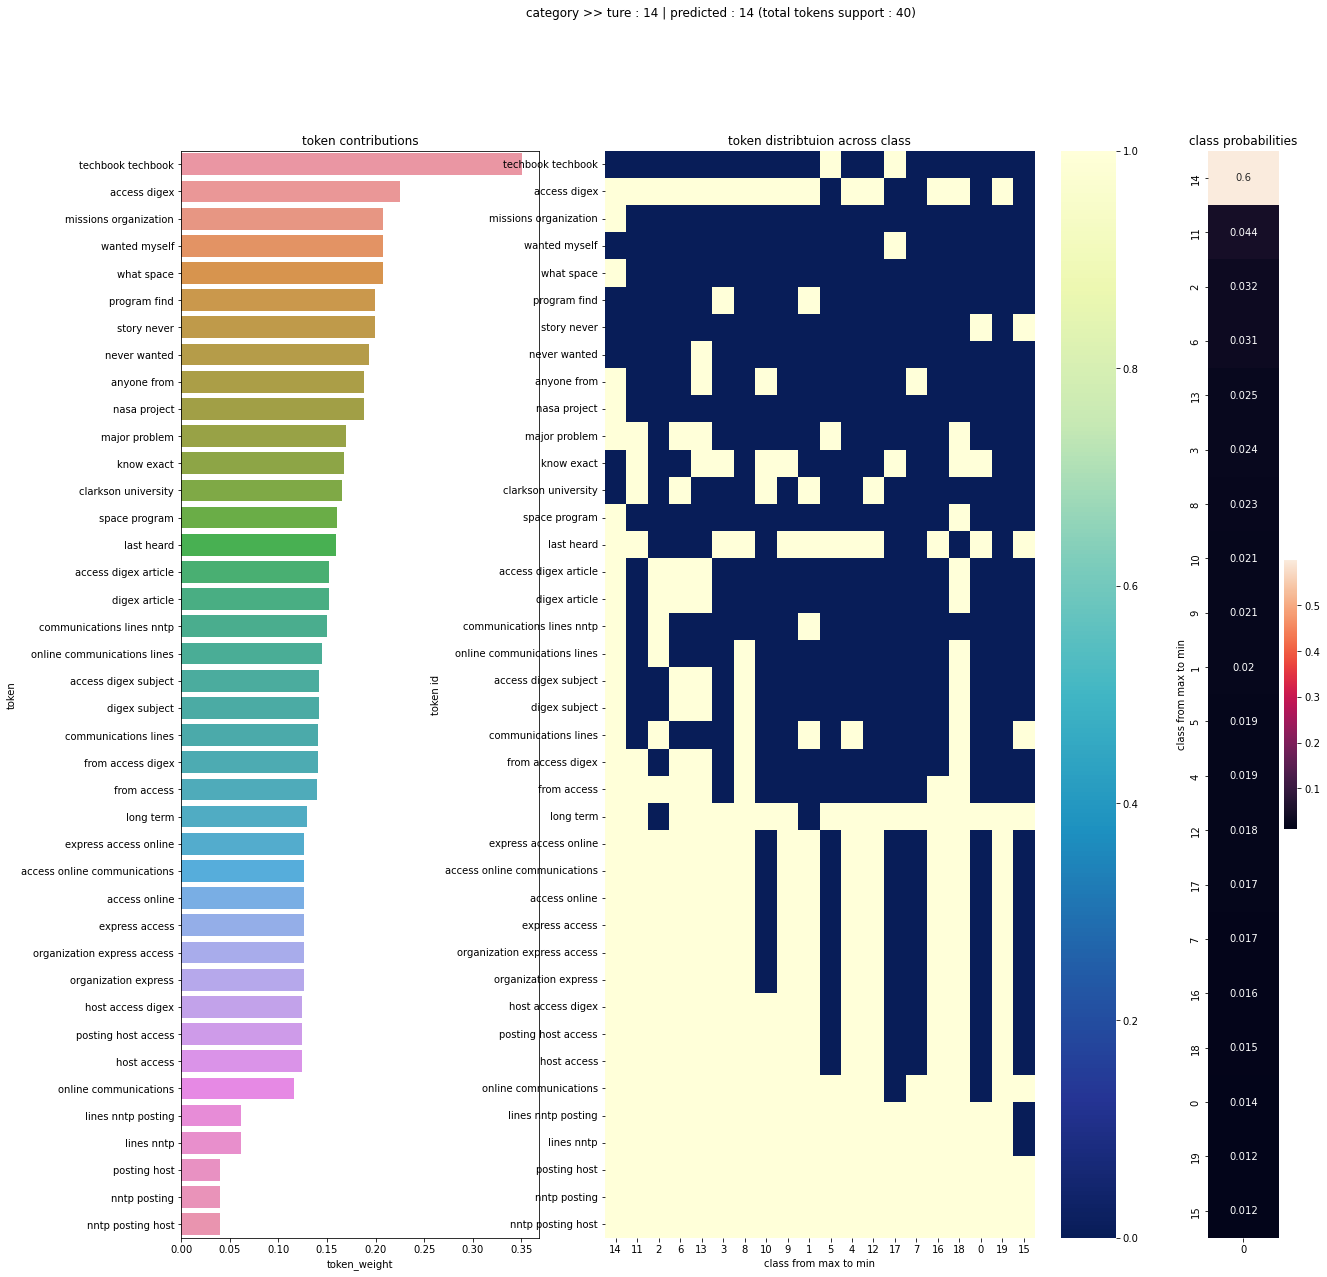

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,20), gridspec_kw={'width_ratios': [4,6,1]})
plt.suptitle(f"category >> ture : {test_target[testing_index]} | predicted : {test_target_pred[testing_index]} (total tokens support : {len(token_index)})")

sns.barplot(data=inspecting_vector_map, x="token_weight", y="token", ax=axes[0])
axes[0].set_title("token contributions")

sns.heatmap(token_category_distribution, cmap="YlGnBu_r",ax=axes[1])
axes[1].set_title("token distribtuion across class")
axes[1].set_xlabel("class from max to min")
axes[1].set_ylabel("token id")

sns.heatmap(class_prediction_probability["class_prob"].to_numpy().reshape(-1,1), annot=True,yticklabels=class_prediction_probability["class_id"],ax=axes[2])
axes[2].set_title("class probabilities")
axes[2].set_ylabel("class from max to min")

plt.show()

## Token Cloud Representation for all the classes on given test sentence

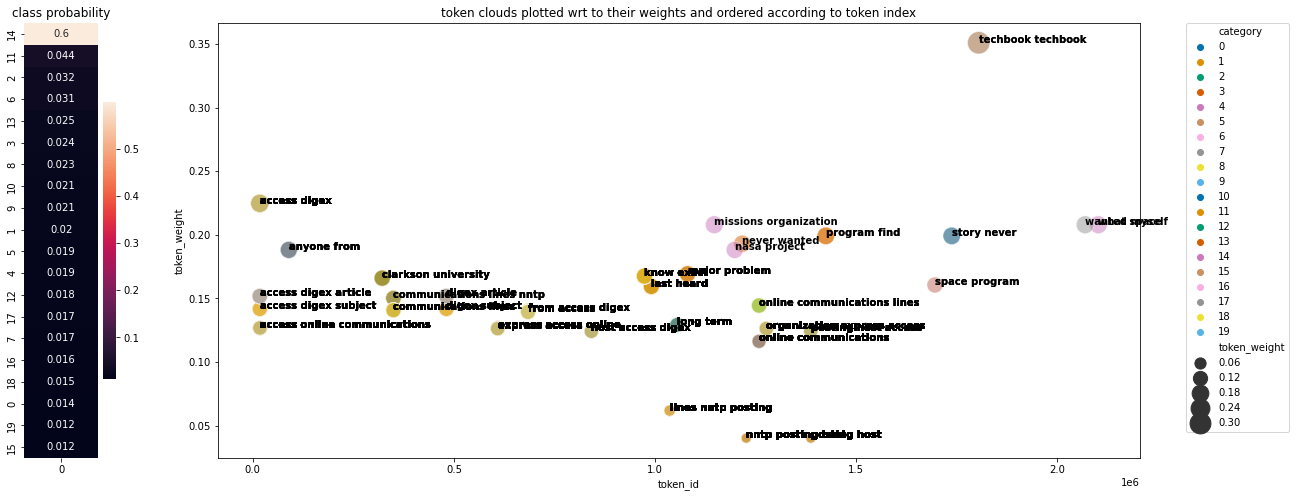

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), gridspec_kw={'width_ratios': [1,10]})

sns.heatmap(class_prediction_probability["class_prob"].to_numpy().reshape(-1,1), 
            annot=True,
            yticklabels=class_prediction_probability["class_id"], ax=axes[0])
axes[0].set_title("class probability")

p1 = sns.scatterplot(data=token_document_class_map, 
                     x="token_id", y="token_weight", 
                     size="token_weight", hue="category",
                     palette='colorblind', legend=True, sizes=(100,500), alpha=0.5, ax=axes[1])

for line in range(0,token_document_class_map.shape[0]):
    p1.text(token_document_class_map["token_id"][line]+0.2, 
            token_document_class_map["token_weight"][line], 
            token_document_class_map["token_name"][line], 
            horizontalalignment='left', 
            size='medium', 
            color='black', 
            weight='semibold')
    
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_title("token clouds plotted wrt to their weights and ordered according to token index")


plt.show()